# Baseline XGBoost model to forecast sales

> Objectives:
>
> - End goal of model is to forecast sales 6 weeks into the future.
> - Train a baseline xgboost model.
> - With minimal feature engineering, and gridsearch on hyperparams, create a base R^2 score to compare future methods against.

# Download dataset
- Manually from https://www.kaggle.com/datasets/aslanahmedov/walmart-sales-forecast/data
- Unzipped and renamed folder `walmart-sales`, and saved in a new folder in the root dir named `datasets`

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

# Dataset Description
- features.csv: Additional data related to the store, department, and regional activity for the given dates.
- train.csv: This is the historical training data, which covers 2010–02–05 to 2012-08-17.
- test.csv: Similar to train.csv, except we have to predict weekly sales.
- stores.csv: Contains anonymized information about the 45 stores, indicating the type and size of the store.

In [2]:
path = Path("../../datasets/walmart-sales")

features_df = pd.read_csv(path/"features.csv")
stores_df = pd.read_csv(path/"stores.csv")
test_df = pd.read_csv(path/"test.csv")
train_df = pd.read_csv(path/"train.csv")

In [3]:
features_df.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [4]:
features_df.describe()

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,8190.000000,8190.000000,8190.000000,4032.000000,2921.000000,3613.000000,3464.000000,4050.000000,7605.000000,7605.000000
mean,23.000000,59.356198,3.405992,7032.371786,3384.176594,1760.100180,3292.935886,4132.216422,172.460809,7.826821
std,12.987966,18.678607,0.431337,9262.747448,8793.583016,11276.462208,6792.329861,13086.690278,39.738346,1.877259
min,1.000000,-7.290000,2.472000,-2781.450000,-265.760000,-179.260000,0.220000,-185.170000,126.064000,3.684000
25%,12.000000,45.902500,3.041000,1577.532500,68.880000,6.600000,304.687500,1440.827500,132.364839,6.634000
50%,23.000000,60.710000,3.513000,4743.580000,364.570000,36.260000,1176.425000,2727.135000,182.764003,7.806000
75%,34.000000,73.880000,3.743000,8923.310000,2153.350000,163.150000,3310.007500,4832.555000,213.932412,8.567000
max,45.000000,101.950000,4.468000,103184.980000,104519.540000,149483.310000,67474.850000,771448.100000,228.976456,14.313000


In [5]:
train_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [6]:
train_df.describe()

,Store,Dept,Weekly_Sales
count,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123
std,12.785297,30.492054,22711.183519
min,1.000000,1.000000,-4988.940000
25%,11.000000,18.000000,2079.650000
50%,22.000000,37.000000,7612.030000
75%,33.000000,74.000000,20205.852500
max,45.000000,99.000000,693099.360000


In [7]:
features_df.columns = features_df.columns.str.lower()
stores_df.columns = stores_df.columns.str.lower()
test_df.columns = test_df.columns.str.lower()
train_df.columns = train_df.columns.str.lower()

# Questions so far:
1. With basic data preparation, what baseline R^2 score can we get using XGBoost?
1. With a handful of grid search hyper parameters, what improvement can we expect before doing too much feature engineering?

In [9]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   store         8190 non-null   int64  
 1   date          8190 non-null   object 
 2   temperature   8190 non-null   float64
 3   fuel_price    8190 non-null   float64
 4   markdown1     4032 non-null   float64
 5   markdown2     2921 non-null   float64
 6   markdown3     3613 non-null   float64
 7   markdown4     3464 non-null   float64
 8   markdown5     4050 non-null   float64
 9   cpi           7605 non-null   float64
 10  unemployment  7605 non-null   float64
 11  isholiday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


# Check for missing values

In [10]:
features_df.isnull().sum()

store              0
date               0
temperature        0
fuel_price         0
markdown1       4158
markdown2       5269
markdown3       4577
markdown4       4726
markdown5       4140
cpi              585
unemployment     585
isholiday          0
dtype: int64

In [12]:
# Dropping isholiday which is contained in train_df as well.
features_df = features_df.drop(columns=["isholiday"])

# Merge train_df and features_df on 'store' and 'date'
merged_df = pd.merge(train_df, features_df, on=['store', 'date'])

# Handle dates
merged_df['date'] = pd.to_datetime(merged_df['date'])
merged_df['year'] = merged_df['date'].dt.year
merged_df['week_of_year'] = merged_df['date'].dt.isocalendar().week

merged_df = merged_df.drop(columns=['date'])

# Handle missing values
merged_df = merged_df.fillna(merged_df.mean())

# Display the first few rows of the merged dataframe
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   store         421570 non-null  int64  
 1   dept          421570 non-null  int64  
 2   weekly_sales  421570 non-null  float64
 3   isholiday     421570 non-null  bool   
 4   temperature   421570 non-null  float64
 5   fuel_price    421570 non-null  float64
 6   markdown1     421570 non-null  float64
 7   markdown2     421570 non-null  float64
 8   markdown3     421570 non-null  float64
 9   markdown4     421570 non-null  float64
 10  markdown5     421570 non-null  float64
 11  cpi           421570 non-null  float64
 12  unemployment  421570 non-null  float64
 13  year          421570 non-null  int32  
 14  week_of_year  421570 non-null  UInt32 
dtypes: UInt32(1), bool(1), float64(10), int32(1), int64(2)
memory usage: 42.6 MB


In [13]:
from sklearn.model_selection import train_test_split

# Remove duplicate rows
X = merged_df.drop(columns=['weekly_sales'])
y = merged_df['weekly_sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Initialize the XGBoost regressor
xgb_model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.01, max_depth=5, random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Print the model
print(xgb_model)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)


In [16]:
from sklearn.metrics import mean_absolute_error, r2_score

# Predict on the test set
y_pred = xgb_model.predict(X_test)

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# Calculate R^2 Score
r2 = r2_score(y_test, y_pred)
print(f"R^2 Score: {r2:.2f}")

Mean Absolute Error (MAE): 6079.5060
R^2 Score: 0.79


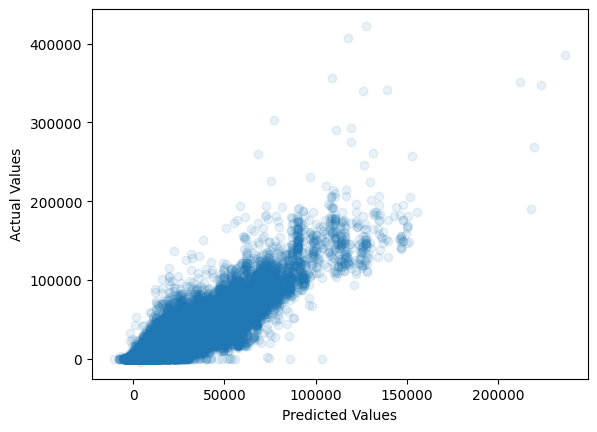

In [17]:
plt.scatter(y_pred, y_test, alpha=0.1)
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

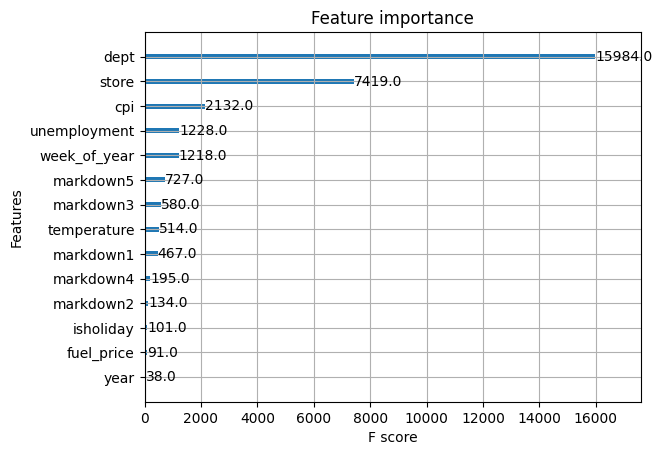

In [18]:
xgb.plot_importance(xgb_model)
plt.show()

In [20]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300, 500, 1000]
}

# Initialize the model
xgb_model = xgb.XGBRegressor()

# Initialize Grid Search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

# Fit Grid Search
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Train the model with the best parameters
best_xgb_model = xgb.XGBRegressor(**best_params)
best_xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = best_xgb_model.predict(X_test)

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# Calculate R^2 Score
r2 = r2_score(y_test, y_pred)
print(f"R^2 Score: {r2:.2f}")

/Users/blakedanson/Library/Caches/pypoetry/virtualenvs/sales-forecasting-explore-DV2QodsZ-py3.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 1000}
Mean Absolute Error (MAE): 1894.8308
R^2 Score: 0.97


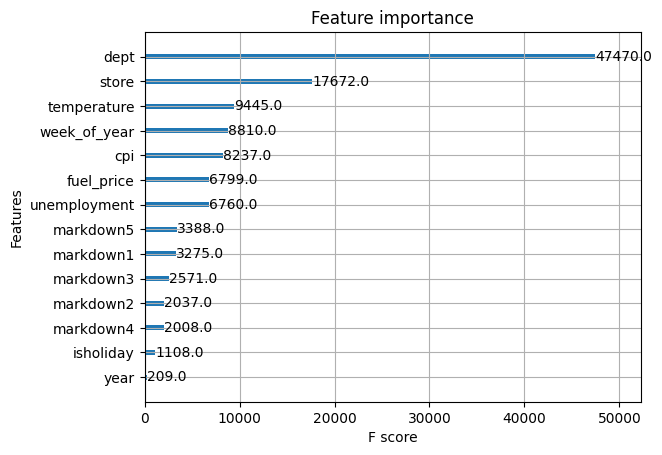

In [21]:
xgb.plot_importance(best_xgb_model)
plt.show()

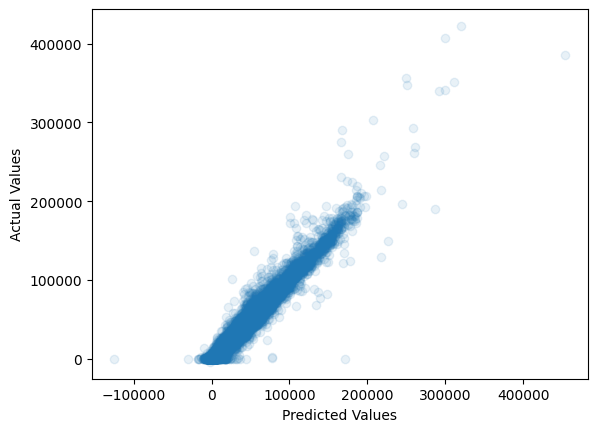

In [22]:
plt.scatter(y_pred, y_test, alpha=0.1)
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

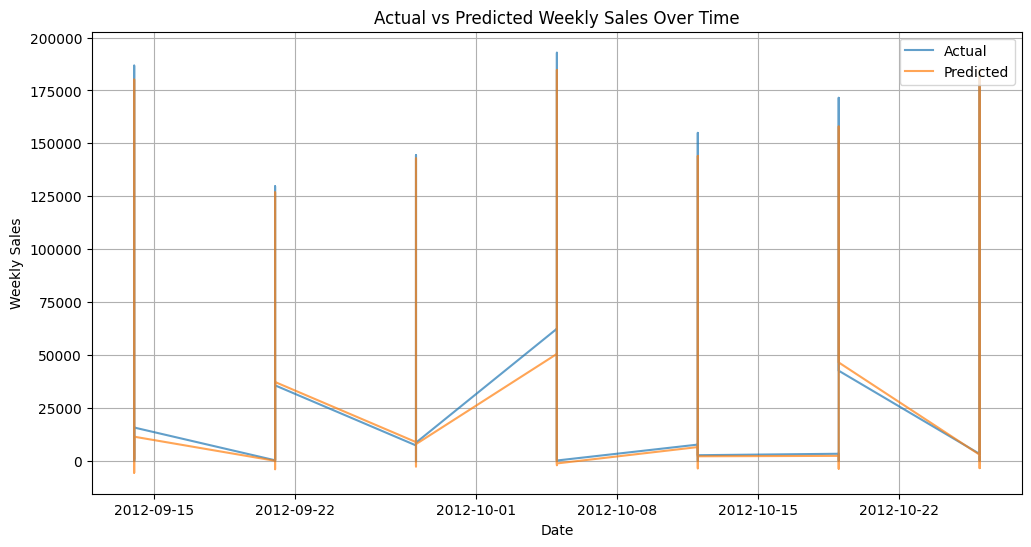

In [25]:
# Ensure the 'date' column is in the test set
X_test['date'] = pd.to_datetime(train_df.loc[X_test.index, 'date'])

# Create a DataFrame with actual and predicted values
results_df = pd.DataFrame({
    'date': X_test['date'],
    'actual': y_test,
    'predicted': y_pred
})

# Sort the DataFrame by date
results_df = results_df.sort_values(by='date')

# Plot the actual and predicted values over time
plt.figure(figsize=(12, 6))
# Filter the DataFrame to include only the last 6 weeks
last_6_weeks = results_df['date'].max() - pd.DateOffset(weeks=6)
filtered_results_df = results_df[results_df['date'] >= last_6_weeks]

# Plot the actual and predicted values over time for the last 6 weeks
plt.plot(filtered_results_df['date'], filtered_results_df['actual'], label='Actual', alpha=0.7)
plt.plot(filtered_results_df['date'], filtered_results_df['predicted'], label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.show()